# 국내 및 국가별 주거, 생활 복지 정책 비교 분석

In [190]:
import pymysql
import pandas as pd
import requests
from bs4 import BeautifulSoup
from collections import Counter
from wordcloud import WordCloud
from konlpy.tag import Okt
from collections import Counter
import matplotlib.pyplot as plt
import platform
from selenium import webdriver
import matplotlib.font_manager as fm

In [69]:
DIR='../Data1/'
FILE=DIR+'주거급여기준임대료.csv'
FILE1=DIR+'주거급여수급자선정기준.csv'
FILE2=DIR+'소득계층별점유형태.csv'

rentDF=pd.read_csv(FILE, encoding='cp949')
rent1DF=pd.read_csv(FILE1, encoding='cp949')
rent2DF=pd.read_csv(FILE2, encoding='cp949', skiprows=1)

In [194]:
# 주거급여기준임대료
rentDF.head(7)

,구분(원/월),1급지(서울),"2급지(경기,인천)","3급지(광역시, 세종시, 수도권 외 특례시)",4급지(그 외 지역)
0,1인,327000,253000,201000,163000
1,2인,367000,283000,224000,183000
2,3인,437000,338000,268000,218000
3,4인,506000,391000,310000,254000
4,5인,524000,404000,320000,262000
5,6인,621000,478000,379000,310000
6,7인,621000,478000,379000,310000


In [133]:
# 주거급여수급자선정기준
rent1DF 

,가구원수,소득인정액
0,1인,894614
1,2인,1499639
2,3인,1929562
3,4인,2355697
4,5인,2771277
5,6인,3177222
6,7인,3579072


In [134]:
def df_row_tuple(csv):
    data=[]
    for rown in range(len(csv)):
        data.append(tuple(csv.iloc[rown]))
    
    return tuple(data)

In [135]:
data = df_row_tuple(rentDF)

In [136]:
def data_iput_output(data,table,coln):
    conn = pymysql.connect(host='localhost', user='root', password='1586', db='house', charset='utf8')
    cur = conn.cursor()
    row = cur.execute('select * from '+table)
    if cur.rowcount == 0:
        sql='insert into ' + table + ' values('
        for i in range(coln):
            if i!=coln-1:
                sql+='%s,'
            else:
                sql += '%s'
        sql+=')'
        cur.executemany(sql, data)
        conn.commit()
        cur.execute('select * from '+table)
        rows = cur.fetchall()
        conn.close()
        
        return pd.DataFrame(rows)
    else:
        cur.execute('select * from '+table)
        rows = cur.fetchall()
        conn.close()
        
        return pd.DataFrame(rows)

In [137]:
data_iput_output(data, 'money_table',5)

,0,1,2,3,4
0,10인,751000,577000,457000,375000
1,11인,751000,577000,457000,375000
2,1인,327000,253000,201000,163000
3,2인,367000,283000,224000,183000
4,3인,437000,338000,268000,218000
5,4인,506000,391000,310000,254000
6,5인,524000,404000,320000,262000
7,6인,621000,478000,379000,310000
8,7인,621000,478000,379000,310000
9,8인,683000,525000,416000,341000


In [41]:
data1 = df_row_tuple(rent1DF)

In [42]:
data_iput_output(data1, 'money1_table',2)

,0,1
0,1인,894614
1,2인,1499639
2,3인,1929562
3,4인,2355697
4,5인,2771277
5,6인,3177222
6,7인,3579072


In [140]:
conn = pymysql.connect(host='localhost', user='root', password='1586', db='house', charset='utf8')
cur = conn.cursor()
sql = '''
select m.*, m1.money 
from money_table m inner join money1_table m1
on m.num = m1.num ;'''
cur.execute(sql)
rows = cur.fetchall()
allDF=pd.DataFrame(rows, columns=['num','firstplace','secondplace','thirdplace','fourthplace','money'])
conn.close()

In [143]:
allDF

,num,firstplace,secondplace,thirdplace,fourthplace,money
0,1인,327000,253000,201000,163000,894614
1,2인,367000,283000,224000,183000,1499639
2,3인,437000,338000,268000,218000,1929562
3,4인,506000,391000,310000,254000,2355697
4,5인,524000,404000,320000,262000,2771277
5,6인,621000,478000,379000,310000,3177222
6,7인,621000,478000,379000,310000,3579072


In [145]:
allDF_x=allDF['num'].to_list()
allDFfir_y=allDF['firstplace'].to_list()
allDFsec_y=allDF['secondplace'].to_list()
allDFthi_y=allDF['thirdplace'].to_list()
allDFfour_y=allDF['fourthplace'].to_list()
allDFmon_y=allDF['money'].to_list()

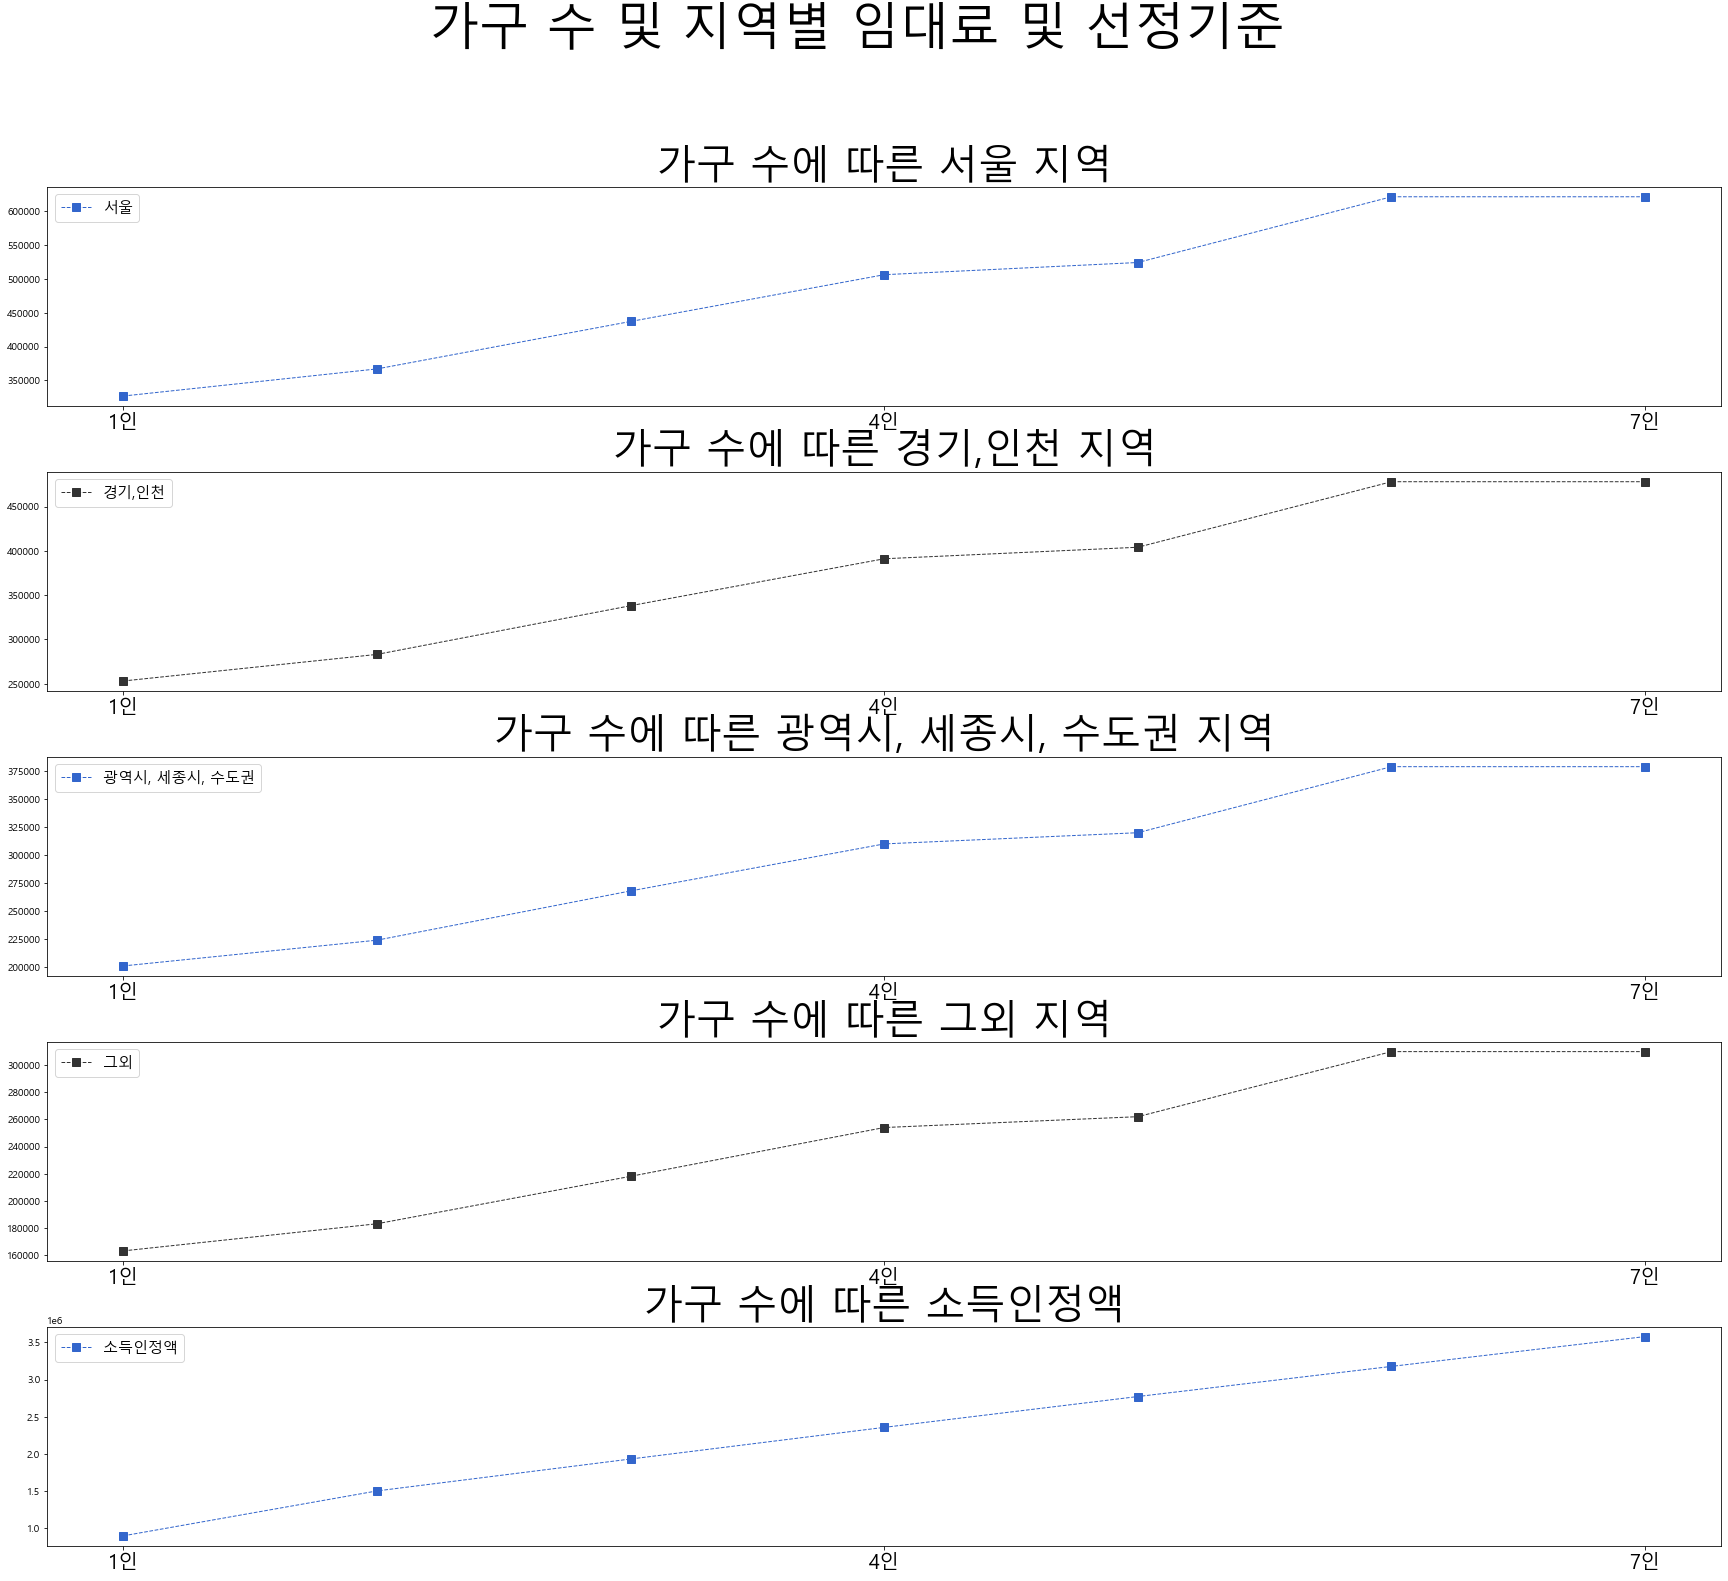

In [168]:
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
else:
    plt.rc('font', family='AppleGothic')
    
fig, axes = plt.subplots(3, 1, figsize=(30, 25))
fig.suptitle('가구 수 및 지역별 임대료 및 선정기준', fontsize=50)   # 메인타이틀 
fig.subplots_adjust(hspace=0.3, wspace=0.3)   # 그래프마다의 거리 지정
plt.subplot(5,1,1)
colors = ['#3366CC']
plt.plot(allDF_x, allDFfir_y, color=colors[0], label='서울', marker='s', markersize=8, linestyle='--', linewidth=1.0)
plt.xticks(ticks=allDF_x, labels=allDF_x, size=20)      #rotation=30
plt.locator_params(axis='x', nbins=len(allDF_x)/3)    # axis로 적용할 축 선택, nbins로 나타낼 간격 수 결정(여기선 1/2로 했음)
plt.legend(fontsize=15)
plt.title('가구 수에 따른 서울 지역', size=40)

plt.subplot(5,1,2)
colors = ['#333333']
plt.plot(allDF_x, allDFsec_y, color=colors[0], label='경기,인천', marker='s', markersize=8, linestyle='--', linewidth=1.0)
plt.xticks(ticks=allDF_x, labels=allDF_x, size=20)      #rotation=30
plt.locator_params(axis='x', nbins=len(allDF_x)/3)    # axis로 적용할 축 선택, nbins로 나타낼 간격 수 결정(여기선 1/2로 했음)
plt.legend(fontsize=15)
plt.title('가구 수에 따른 경기,인천 지역', size=40)

plt.subplot(5,1,3)
colors = ['#3366CC']
plt.plot(allDF_x, allDFthi_y, color=colors[0], label='광역시, 세종시, 수도권', marker='s', markersize=8, linestyle='--', linewidth=1.0)
plt.xticks(ticks=allDF_x, labels=allDF_x, size=20)      #rotation=30
plt.locator_params(axis='x', nbins=len(allDF_x)/3)    # axis로 적용할 축 선택, nbins로 나타낼 간격 수 결정(여기선 1/2로 했음)
plt.legend(fontsize=15)
plt.title('가구 수에 따른 광역시, 세종시, 수도권 지역', size=40)

plt.subplot(5,1,4)
colors = ['#333333']
plt.plot(allDF_x, allDFfour_y, color=colors[0], label='그외', marker='s', markersize=8, linestyle='--', linewidth=1.0)
plt.xticks(ticks=allDF_x, labels=allDF_x, size=20)      #rotation=30
plt.locator_params(axis='x', nbins=len(allDF_x)/3)    # axis로 적용할 축 선택, nbins로 나타낼 간격 수 결정(여기선 1/2로 했음)
plt.legend(fontsize=15)
plt.title('가구 수에 따른 그외 지역', size=40)

plt.subplot(5,1,5)
colors = ['#3366CC']
plt.plot(allDF_x, allDFmon_y, color=colors[0], label='소득인정액', marker='s', markersize=8, linestyle='--', linewidth=1.0)
plt.xticks(ticks=allDF_x, labels=allDF_x, size=20)      #rotation=30
plt.locator_params(axis='x', nbins=len(allDF_x)/3)    # axis로 적용할 축 선택, nbins로 나타낼 간격 수 결정(여기선 1/2로 했음)
plt.legend(fontsize=15)
plt.title('가구 수에 따른 소득인정액', size=40)

plt.show()

In [196]:
rent2DF.head(5)

,지역,소득구분,단독주택,아파트,연립주택,다세대주택,비거주용 건물내주택,주택이외의 거처,계
0,전국,전체,31.0,51.1,2.1,9.4,1.6,4.8,100.0
1,전국,저소득층,47.3,31.6,2.3,9.7,1.5,7.6,100.0
2,전국,중소득층,24.4,57.8,2.4,10.1,1.9,3.4,100.0
3,전국,고소득층,11.9,77.5,1.5,6.4,1.1,1.7,100.0
4,수도권,전체,23.1,51.7,2.4,15.1,1.5,6.2,100.0


In [195]:
rent2DF.rename(columns={'시도구분(1)':'지역',	'소득구분(1)':'소득구분', '2020':'아파트', '2020.1':'연립주택', '2020.2':'다세대주택',
                       '2020.3':'다세대주택', '2020.4':'비거주용 건물내주택', '2020.5':'주택이외 거처','2020.6':'계'}, inplace=True)
rent2DF

,지역,소득구분,단독주택,아파트,연립주택,다세대주택,비거주용 건물내주택,주택이외의 거처,계
0,전국,전체,31.0,51.1,2.1,9.4,1.6,4.8,100.0
1,전국,저소득층,47.3,31.6,2.3,9.7,1.5,7.6,100.0
2,전국,중소득층,24.4,57.8,2.4,10.1,1.9,3.4,100.0
3,전국,고소득층,11.9,77.5,1.5,6.4,1.1,1.7,100.0
4,수도권,전체,23.1,51.7,2.4,15.1,1.5,6.2,100.0
5,수도권,저소득층,35.8,32.1,2.8,16.8,1.3,11.2,100.0
6,수도권,중소득층,21.2,52.8,2.9,16.7,1.8,4.6,100.0
7,수도권,고소득층,7.4,78.8,1.4,9.2,1.5,1.8,100.0
8,광역시 등,전체,29.0,58.7,1.5,5.9,1.5,3.4,100.0
9,광역시 등,저소득층,44.0,38.9,1.7,7.6,1.9,5.9,100.0


In [77]:
rent2DF.to_csv('hojin.csv', encoding='cp949')

In [78]:
data2 = df_row_tuple(rent2DF)

In [85]:
data3 = data_iput_output(data2, '소득계층점유',9)
data3.columns=['0','지역','소득구분','단독주택','아파트','연립주택','다세대주택','비주거용 건물내 주택','주택 이외 거처','계']
# 소득계층별점유형태
data3

,0,지역,소득구분,단독주택,아파트,연립주택,다세대주택,비주거용 건물내 주택,주택 이외 거처,계
0,0,전국,전체,31.0,51.1,2.1,9.4,1.6,4.8,100.0
1,1,전국,저소득층,47.3,31.6,2.3,9.7,1.5,7.6,100.0
2,2,전국,중소득층,24.4,57.8,2.4,10.1,1.9,3.4,100.0
3,3,전국,고소득층,11.9,77.5,1.5,6.4,1.1,1.7,100.0
4,4,수도권,전체,23.1,51.7,2.4,15.1,1.5,6.2,100.0
5,5,수도권,저소득층,35.8,32.1,2.8,16.8,1.3,11.2,100.0
6,6,수도권,중소득층,21.2,52.8,2.9,16.7,1.8,4.6,100.0
7,7,수도권,고소득층,7.4,78.8,1.4,9.2,1.5,1.8,100.0
8,8,광역시 등,전체,29.0,58.7,1.5,5.9,1.5,3.4,100.0
9,9,광역시 등,저소득층,44.0,38.9,1.7,7.6,1.9,5.9,100.0


# 미국의 저소득층을 위한 주요 주거지원 프로그램

In [123]:
driver = webdriver.Chrome(r'C:\Users\User\chromedriver.exe')
driver.get('https://finfong.com/%EB%AF%B8%EA%B5%AD%EC%9D%98-%EC%A0%80%EC%86%8C%EB%93%9D%EC%B8%B5%EC%9D%84-%EC%9C%84%ED%95%9C-%EC%A3%BC%EC%9A%94-%EC%A3%BC%EA%B1%B0%EC%A7%80%EC%9B%90-%ED%94%84%EB%A1%9C%EA%B7%B8%EB%9E%A8/')

html = driver.page_source
soup = BeautifulSoup(html, 'html.parser')
soup1=soup.find_all('div', {'class':'td-post-content'})
result=[]
for i in soup1:
    result.append(i.text)
driver.quit()

In [124]:
result

['\n\n\n\n\n\n\n\n\n\n￮ 미국 정부에서 보조하는 주거지원 프로그램은 <표 6-1>에서 보는 바와 같이 다양한 계층과 요구를 수용하기 위하여 지속적으로 변화를 추구해 왔음\n‒ 특히 1990년대까지의 주거지원 정책이 임차인의 임대보조금을 지원하는데 주력하였다면, 최근의 주거지원 정책은 임차인의 주택소유권 확보, 저소득층 임차인이 질 좋고 안전한 임대주택에서 거주할 수 있도록 하는 지원, 평등한 주거기회의 확대 등으로 특징지을 수 있음\n￮ 미국의 주거지원 프로그램에 집행한 비용을 정리한 Landis와 McCluer(2010)의 논문에서는 저소득층의 임차인들에게 질 좋고 지불가능한 임대주택을 위한 정책이 크게 공공임대주택(public housing)의 공급, 바우처(vouchers) 제도, 저소득층 주택을 위한 세금 혜택(Low Income Housing Tax Credit) 등이라고 분류하고 있으며 2008년 미국 연방정부가 주택지원을 위한 지출액을 다음과 같이 정리하고 있음\n‒ 총 213,545 백만 달러(2천억불 이상의 지출규모) 중 가장 많은 비중을 차지하는 항목은 자가소유 가구를 위한 모기지 이자감면(Mortgage interest deduction)으로 미국의 국세청(IRS)에서 지출하는 비용이며 총 94,800 백만 달러(900억불 이상)으로 나타남\n․ 이는 실제로 주택 소유자에게 지불하는 비용이 아니라, 주택 소유자가 매년 지출하는 모기지 이자에 대한 세금을 연말에 세금정산을 통해서 돌려받는 형태임\n‒ HUD에서 주도하는 저소득층을 위한 주거지원 프로그램 중에서는 주거선택 바우처 프로그램(Housing Choice Voucher Program) 또는 Section 8이 가장 많은 비중을 차지하며, 총 8,545 백만 달러(80억불이상)의 규모임\n․ 다음으로는 HOPE VI를 포함한 공공임대주택(Public housing)에 대한 지원이 77억불, 저소득층 주택 세제 감면(Low Income Housing Tax Credit)

In [129]:
from konlpy.tag import Okt

okt = Okt()
noun_adj_list = []
for data in result:
    sentences_tag = okt.pos(data)
    # tag가 명사인 단어들만 noun_adj_list에 넣어준다.
    for word, tag in sentences_tag:
        if tag in ['Noun']:
            noun_adj_list.append(word)

In [138]:
noun_adj_list
counts = Counter(noun_adj_list)
tags = counts.most_common(50)
tags

[('주택', 96),
 ('프로그램', 74),
 ('가구', 47),
 ('보조', 46),
 ('위', 45),
 ('소득', 43),
 ('임대', 37),
 ('임차', 36),
 ('층', 32),
 ('임대주택', 30),
 ('바', 29),
 ('처', 27),
 ('섹션', 27),
 ('함', 25),
 ('수', 23),
 ('위해', 23),
 ('임대료', 22),
 ('이', 21),
 ('지원', 20),
 ('의', 20),
 ('비용', 19),
 ('개발', 18),
 ('보조금', 17),
 ('제공', 17),
 ('정부', 15),
 ('지불', 15),
 ('를', 15),
 ('지역', 15),
 ('주거', 14),
 ('것', 13),
 ('등', 11),
 ('지출', 11),
 ('사용', 11),
 ('계약', 11),
 ('주거지', 10),
 ('장애인', 10),
 ('기관', 10),
 ('경우', 10),
 ('구입', 10),
 ('기준', 10),
 ('수입', 10),
 ('중', 9),
 ('소유', 9),
 ('대한', 9),
 ('임', 9),
 ('로', 9),
 ('프로젝트', 9),
 ('해당', 9),
 ('미국', 8),
 ('세금', 8)]

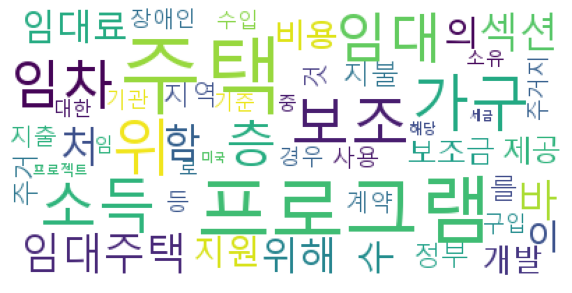

In [139]:
# WordCloud를 생성한다.

if platform.system() == 'Windows':
    path = r'c:\Windows\Fonts\malgun.ttf'
elif platform.system() == 'Darwin': # Mac OS
    path = r'/System/Library/Fonts/AppleGothic'
else:
    path = r'/usr/share/fonts/truetype/name/NanumMyeongjo.ttf'

wc = WordCloud(font_path=path, background_color="white", max_font_size=60)
cloud1 = wc.generate_from_frequencies(dict(tags))

# 생성된 WordCloud를 test.jpg로 보낸다.
#cloud.to_file('test.jpg')

plt.figure(figsize=(10, 8))
plt.axis('off')
plt.imshow(cloud1)
plt.show()

## 독일 저소득층 주거비용 상승에 따른 주거수당 증액 방안

In [184]:
driver = webdriver.Chrome(r'C:\Users\User\chromedriver.exe')
driver.get('https://blog.naver.com/swf1004/221631056531')
driver.switch_to.frame('mainFrame')

html = driver.page_source
soup1 = BeautifulSoup(html, 'html.parser')

whole_border = soup1.find('div', {'id': 'whole-border'})
results = whole_border.find_all('div', {'class': 'se-module'})

result1=[]
for result in results:
    print(result.text)
    result1.append(result.text)


[해외복지이야기] 독일 저소득층 ‘주거비용 상승’에 따른 주거수당 증액 방안 
미국의 정치인이자 과학자였던 벤자민 프랭클린은 "오래 살기를 바라기 보다 잘 살기를 바라라."라고 했죠. 잘 산다는 건 그저 굶지않고 살아감을 넘어 평온하고 걱정없이 살아감을 이야기하는 것이겠죠? 그런데 최근 독일에서는 월급의 절반을 월세로 내야 할 만큼 살인적인 집값 상승으로 인해 많은 사람들의 걱정이 이어지고 있습니다. 그에 따라 집값 상승은 최근 독일의 중요한 사회문제입니다. 유럽연합 통계청 보고에 따르면 독일인의 절반가량은 월세를 내며 살고 있다고 해요. 이는 유럽연합 평균인 29.9%보다 높은 비율이며, 월세 거주자의 비율은 대도시가 더 높아요. 일간지 <빌트> 보도에 따르면 베를린 시민의 85%가 월세 생활을 하고 있고, 2008년에 비해 집세가 무려 80% 나 상승했답니다. 독일에서는 최근 몇 년간 일부 지역에서 집세가 급격하게 상승하게 되면서, 주거공급에 문제가 생기게 되었고 그로 인해 저소득층의 주거문제가 크게 대두하였죠. 자세한 주거문제에 대한 상황 확인해볼게요.



독일 ‘주거비용 상승’ 주거 수당증액방안집값상승으로 인한 주거위기
독일에서는 최근 몇 년간 일부 지역에서 집세가 급격하게 상승하게 되면서, 주거공급에 문제가 생기게 되었고 그로 인해 저소득층의 주거문제가 크게 대두되었죠. 조사에 따르면 대도시 거주자 중 상당수가 월세 상승으로 인해 원래 살던 지역을 떠난 것으로 확인했으며, 직장을 옮기게 되어 이사를 가야 함에도 불구하고 집값 때문에 계속 거주하는 가구도 상당수였습니다. 독일 대학생들 역시 가장 큰 경제적 스트레스는 집세 상승이에요. 독일경제연구소가 조사한 바로는 베를린 대학가 아파트의 임대료가 1년 전과 비교했을 때 무려 67.3%가 올랐고, 전국적으로 대학가 아파트 임대료가 빠르게 오르고 있다고 발표했답니다. 유로스타트(유럽연합 통계 기구)가 유럽 각국의 2015년 기준 주거비용을 산출한 통계에 따르면 저소득층의 주거비용이 다른 유럽 국가들과 비

In [185]:
result1

['\n[해외복지이야기] 독일 저소득층 ‘주거비용 상승’에 따른 주거수당 증액 방안 ',
 '미국의 정치인이자 과학자였던 벤자민 프랭클린은 "오래 살기를 바라기 보다 잘 살기를 바라라."라고 했죠. 잘 산다는 건 그저 굶지않고 살아감을 넘어 평온하고 걱정없이 살아감을 이야기하는 것이겠죠? 그런데 최근 독일에서는 월급의 절반을 월세로 내야 할 만큼 살인적인 집값 상승으로 인해 많은 사람들의 걱정이 이어지고 있습니다. 그에 따라 집값 상승은 최근 독일의 중요한 사회문제입니다. 유럽연합 통계청 보고에 따르면 독일인의 절반가량은 월세를 내며 살고 있다고 해요. 이는 유럽연합 평균인 29.9%보다 높은 비율이며, 월세 거주자의 비율은 대도시가 더 높아요. 일간지 <빌트> 보도에 따르면 베를린 시민의 85%가 월세 생활을 하고 있고, 2008년에 비해 집세가 무려 80% 나 상승했답니다. 독일에서는 최근 몇 년간 일부 지역에서 집세가 급격하게 상승하게 되면서, 주거공급에 문제가 생기게 되었고 그로 인해 저소득층의 주거문제가 크게 대두하였죠. 자세한 주거문제에 대한 상황 확인해볼게요.',
 '\n\n',
 '독일 ‘주거비용 상승’ 주거 수당증액방안집값상승으로 인한 주거위기',
 '독일에서는 최근 몇 년간 일부 지역에서 집세가 급격하게 상승하게 되면서, 주거공급에 문제가 생기게 되었고 그로 인해 저소득층의 주거문제가 크게 대두되었죠. 조사에 따르면 대도시 거주자 중 상당수가 월세 상승으로 인해 원래 살던 지역을 떠난 것으로 확인했으며, 직장을 옮기게 되어 이사를 가야 함에도 불구하고 집값 때문에 계속 거주하는 가구도 상당수였습니다. 독일 대학생들 역시 가장 큰 경제적 스트레스는 집세 상승이에요. 독일경제연구소가 조사한 바로는 베를린 대학가 아파트의 임대료가 1년 전과 비교했을 때 무려 67.3%가 올랐고, 전국적으로 대학가 아파트 임대료가 빠르게 오르고 있다고 발표했답니다. 유로스타트(유럽연합 통계 기구)가 유럽 각국의 2015년 기준 주거비용을 산출한 통계에 따르면 저소득

In [186]:
from konlpy.tag import Okt

okt = Okt()
noun_adj_list = []
for data in result1:
    sentences_tag = okt.pos(data)
    # tag가 명사인 단어들만 noun_adj_list에 넣어준다.
    for word, tag in sentences_tag:
        if tag in ['Noun']:
            noun_adj_list.append(word)

In [187]:
noun_adj_list
counts = Counter(noun_adj_list)
tags = counts.most_common(50)
tags

[('주거', 32),
 ('상승', 19),
 ('비용', 15),
 ('독일', 13),
 ('소득', 13),
 ('것', 10),
 ('방안', 9),
 ('층', 8),
 ('문제', 8),
 ('집세', 7),
 ('월세', 6),
 ('가구', 6),
 ('복지', 5),
 ('증액', 5),
 ('증가', 5),
 ('주택', 5),
 ('수당', 4),
 ('최근', 4),
 ('집값', 4),
 ('지역', 4),
 ('주장', 4),
 ('사회', 3),
 ('유럽연합', 3),
 ('비율', 3),
 ('거주', 3),
 ('공급', 3),
 ('대한', 3),
 ('위기', 3),
 ('함', 3),
 ('국가', 3),
 ('정책', 3),
 ('안정', 3),
 ('지원', 3),
 ('거수', 3),
 ('점', 3),
 ('지적', 3),
 ('이야기', 2),
 ('살기', 2),
 ('걱정', 2),
 ('절반', 2),
 ('만큼', 2),
 ('사람', 2),
 ('통계청', 2),
 ('살', 2),
 ('평균', 2),
 ('대도시', 2),
 ('더', 2),
 ('베를린', 2),
 ('무려', 2),
 ('나', 2)]

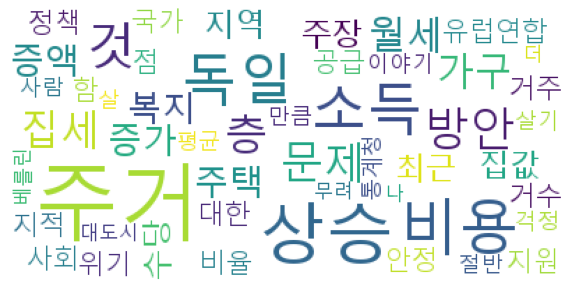

In [188]:
# WordCloud를 생성한다.

if platform.system() == 'Windows':
    path = r'c:\Windows\Fonts\malgun.ttf'
elif platform.system() == 'Darwin': # Mac OS
    path = r'/System/Library/Fonts/AppleGothic'
else:
    path = r'/usr/share/fonts/truetype/name/NanumMyeongjo.ttf'

wc = WordCloud(font_path=path, background_color="white", max_font_size=60)
cloud1 = wc.generate_from_frequencies(dict(tags))

# 생성된 WordCloud를 test.jpg로 보낸다.
#cloud.to_file('test.jpg')

plt.figure(figsize=(10, 8))
plt.axis('off')
plt.imshow(cloud1)
plt.show()

# SQL DB

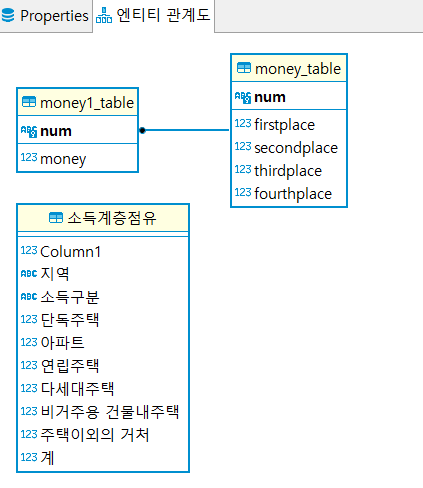

# 결론
- 한국과 국외(미국, 독일) 자료를 분석한 결과 공통적으로 각 나라별 저소득층을 위해 임대 주택을 공급하고 임대료 및 주거급여를 지원하는 것을 알 수 있었습니다.
- 국외와 비교했을 때 급여수급자선정기준에서 그 기준이 너무 낮았다고 생각합니다.
- 우리나라도 급여소득 인정액을 상향하고, 저소득 가구를 명확히 해서 임대주택을 공급할 필요성이 있다고 생각합니다.

# 출처
- https://www.lh.or.kr/contents/cont.do?sCode=user&mPid=248&mId=247&menuYear=
- https://kosis.kr/statHtml/statHtml.do?orgId=116&tblId=DT_MLTM_6689&vw_cd=MT_ZTITLE&list_id=I1_8&scrId=&seqNo=&lang_mode=ko&obj_var_id=&itm_id=&conn_path=E1
- https://blog.naver.com/swf1004/221631056531